In [1]:
import tensorflow as tf


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# 设置TensorFlow使用单个GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# 导入其他库
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt

In [4]:
# 从本地CSV文件加载数据
def get_data_from_csv(file_path='E:/Haibo_Fang23-24-Dissertation/report/AAPL_10_years_data.csv'):
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    data = df['Close'].values.reshape(-1, 1)
    return data

In [5]:
# 创建模型
def create_model(params):
    model = Sequential()
    model.add(LSTM(units=params['units'], return_sequences=True, input_shape=(60, 1)))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(units=params['units'], return_sequences=False))
    model.add(Dropout(params['dropout']))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
# 训练模型
def train_model(params):
    data = get_data_from_csv()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    sequence_length = 60
    train_size = int(len(data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - sequence_length:]
    
    x_train, y_train = [], []
    for i in range(sequence_length, len(train_data)):
        x_train.append(train_data[i-sequence_length:i, 0])
        y_train.append(train_data[i, 0])
    
    x_test, y_test = [], []
    for i in range(sequence_length, len(test_data)):
        x_test.append(test_data[i-sequence_length:i, 0])
        y_test.append(test_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    model = create_model(params)
    model.fit(x_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=0)
    loss = model.evaluate(x_test, y_test, verbose=0)
    return {'loss': loss, 'status': STATUS_OK}

In [7]:

# 定义贝叶斯优化搜索空间
space = {
    'units': hp.choice('units', [50, 100, 150, 200]),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'epochs': hp.choice('epochs', [10, 20, 30, 40, 50]),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

In [8]:

# 执行贝叶斯优化
trials = Trials()
best = fmin(fn=train_model, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print(best)

100%|██████████| 50/50 [39:02<00:00, 46.86s/trial, best loss: 0.000213817780604586]  
{'batch_size': 0, 'dropout': 0.0310090515871157, 'epochs': 2, 'units': 3}


In [9]:
# 使用最佳参数训练最终模型
best_params = {
    'units': [50, 100, 150, 200][best['units']],
    'dropout': best['dropout'],
    'epochs': [10, 20, 30, 40, 50][best['epochs']],
    'batch_size': [16, 32, 64][best['batch_size']]
}


In [10]:
data = get_data_from_csv()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [11]:
sequence_length = 60
train_size = int(len(data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - sequence_length:]

In [12]:
x_train, y_train = [], []
for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

x_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = create_model(best_params)
model.fit(x_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)


Epoch 1/30
122/122 [==============================] - 4s 17ms/step - loss: 0.0024
Epoch 2/30
122/122 [==============================] - 2s 15ms/step - loss: 3.4282e-04
Epoch 3/30
122/122 [==============================] - 2s 15ms/step - loss: 3.2506e-04
Epoch 4/30
122/122 [==============================] - 2s 15ms/step - loss: 3.4806e-04
Epoch 5/30
122/122 [==============================] - 2s 15ms/step - loss: 3.1620e-04
Epoch 6/30
122/122 [==============================] - 2s 15ms/step - loss: 2.3388e-04
Epoch 7/30
122/122 [==============================] - 2s 15ms/step - loss: 2.9630e-04
Epoch 8/30
122/122 [==============================] - 2s 16ms/step - loss: 2.5008e-04
Epoch 9/30
122/122 [==============================] - 2s 16ms/step - loss: 2.4941e-04
Epoch 10/30
122/122 [==============================] - 2s 15ms/step - loss: 2.5909e-04
Epoch 11/30
122/122 [==============================] - 2s 16ms/step - loss: 3.1023e-04
Epoch 12/30
122/122 [==============================] - 2

In [13]:
# 预测测试集
test_predictions = model.predict(x_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:
# 评估模型
mse = mean_squared_error(y_test, test_predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 8.140596284840807


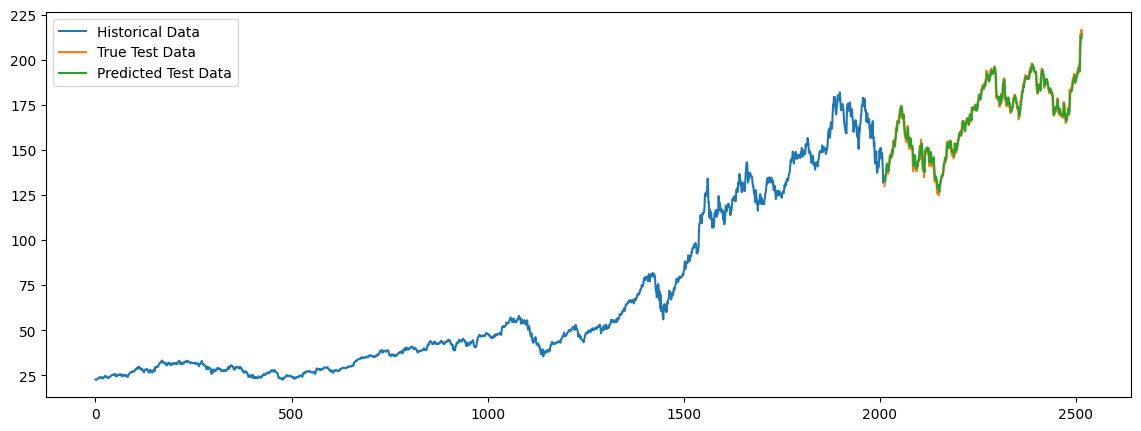

In [16]:
# 确认 historical_data 和 y_test 长度匹配
historical_data = data[:train_size].flatten()
test_data = data[train_size:].flatten()

# 确认绘图时的 x 和 y 轴长度匹配
plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(historical_data)), historical_data, label='Historical Data')
plt.plot(np.arange(len(historical_data), len(historical_data) + len(test_data)), y_test.flatten(), label='True Test Data')
plt.plot(np.arange(len(historical_data), len(historical_data) + len(test_data)), test_predictions.flatten(), label='Predicted Test Data')
plt.legend()
plt.show()

In [17]:
# 训练并评估模型后，打印最佳参数
print("Best hyperparameters:", best)

best_params = {
    'units': [50, 100, 150, 200][best['units']],
    'dropout': best['dropout'],
    'epochs': [10, 20, 30, 40, 50][best['epochs']],
    'batch_size': [16, 32, 64][best['batch_size']]
}

print("Best Parameters after Bayesian Optimization:", best_params)


Best hyperparameters: {'batch_size': 0, 'dropout': 0.0310090515871157, 'epochs': 2, 'units': 3}
Best Parameters after Bayesian Optimization: {'units': 200, 'dropout': 0.0310090515871157, 'epochs': 30, 'batch_size': 16}


In [19]:
# 评估模型
from sklearn.metrics import mean_absolute_error


mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 8.140596284840807
Root Mean Squared Error: 2.8531730204880335
Mean Absolute Error: 2.1458909776475696
